# 1. instala libs

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 24.0 MB/s eta 0:00:00


In [3]:
!pip install -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 24.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.9.0
    Uninstalling ray-2.9.0:
      Successfully uninstalled ray-2.9.0


In [4]:
# desativa alguns outputs para deixar mais limpo
import warnings
warnings.filterwarnings('ignore')

# importa libs
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import Video

In [5]:
# configura o visual para o seaborn
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

# 2. carrega o modelo pré-treinado YoLOv8n-seg

In [6]:
"""
A linha de modelos YOLOv8-seg varia de nano a xlarge, cada um equilibrando de maneira diferente a precisão e a velocidade.
Enquanto os modelos maiores oferecem maior precisão, eles o fazem em detrimento do tempo de resposta.
Para a nossa tarefa de Segmentação de Buracos, que exige processamento rápido, o YOLOv8n-seg é o modelo escolhido.
Ele é projetado para a inferência mais rápida, tornando-o altamente adequado para aplicações em tempo real.
"""

# carrega o YoLOV8 nano pré-treinado
model = YOLO('yolov8n-seg.pt')

100%|██████████| 6.73M/6.73M [00:00<00:00, 117MB/s]


# 3. dataset

In [7]:
"""
O conjunto de dados inclui 780 imagens, sendo 720 para treinamento e 60 para validação em uma resolução de 640x640.
"""

# define o caminho do dataset
dataset_path = 'buracos-segmentacao-yolov8

# configura o arquivo .yaml (serve para configurar o modelo indicando a estrutura de treino e validação)
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# carrega e exibe detalhes do arquivo .yaml
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole_segmentation_yolov8
  url: https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1
  version: 1
  workspace: farzad
train: ../train/images
val: ../valid/images



In [8]:
# configura os caminhos de treino e validação
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# inicializa os contadores para as imagens
num_train_images = 0
num_valid_images = 0

# inicializa sets para deixar imagens únicas
train_image_sizes = set()
valid_image_sizes = set()

# checa os arquivos de treino
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# checa os arquivos de validação
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# exibe os resultados
print(f"Número de imagens no treino: {num_train_images}")
print(f"Número de imagens no teste: {num_valid_images}")

# checa se todos os arquivos de treino tem o mesmo tamanho
if len(train_image_sizes) == 1:
    print(f"Todas as imagens de treino tem o mesmo tamanho: {train_image_sizes.pop()}")
else:
    print("As imagens de treino tem tamanhos diferentes.")

# checa se todos os arquivos de validação tem o mesmo tamanho
if len(valid_image_sizes) == 1:
    print(f"Todas as imagens de validação tem o mesmo tamanho: {valid_image_sizes.pop()}")
else:
    print("As imagens de validação tem tamanhos diferentes.")

Número de imagens no treino: 720
Número de imagens no teste: 60
Todas as imagens de treino tem o mesmo tamanho: (640, 640)
Todas as imagens de validação tem o mesmo tamanho: (640, 640)


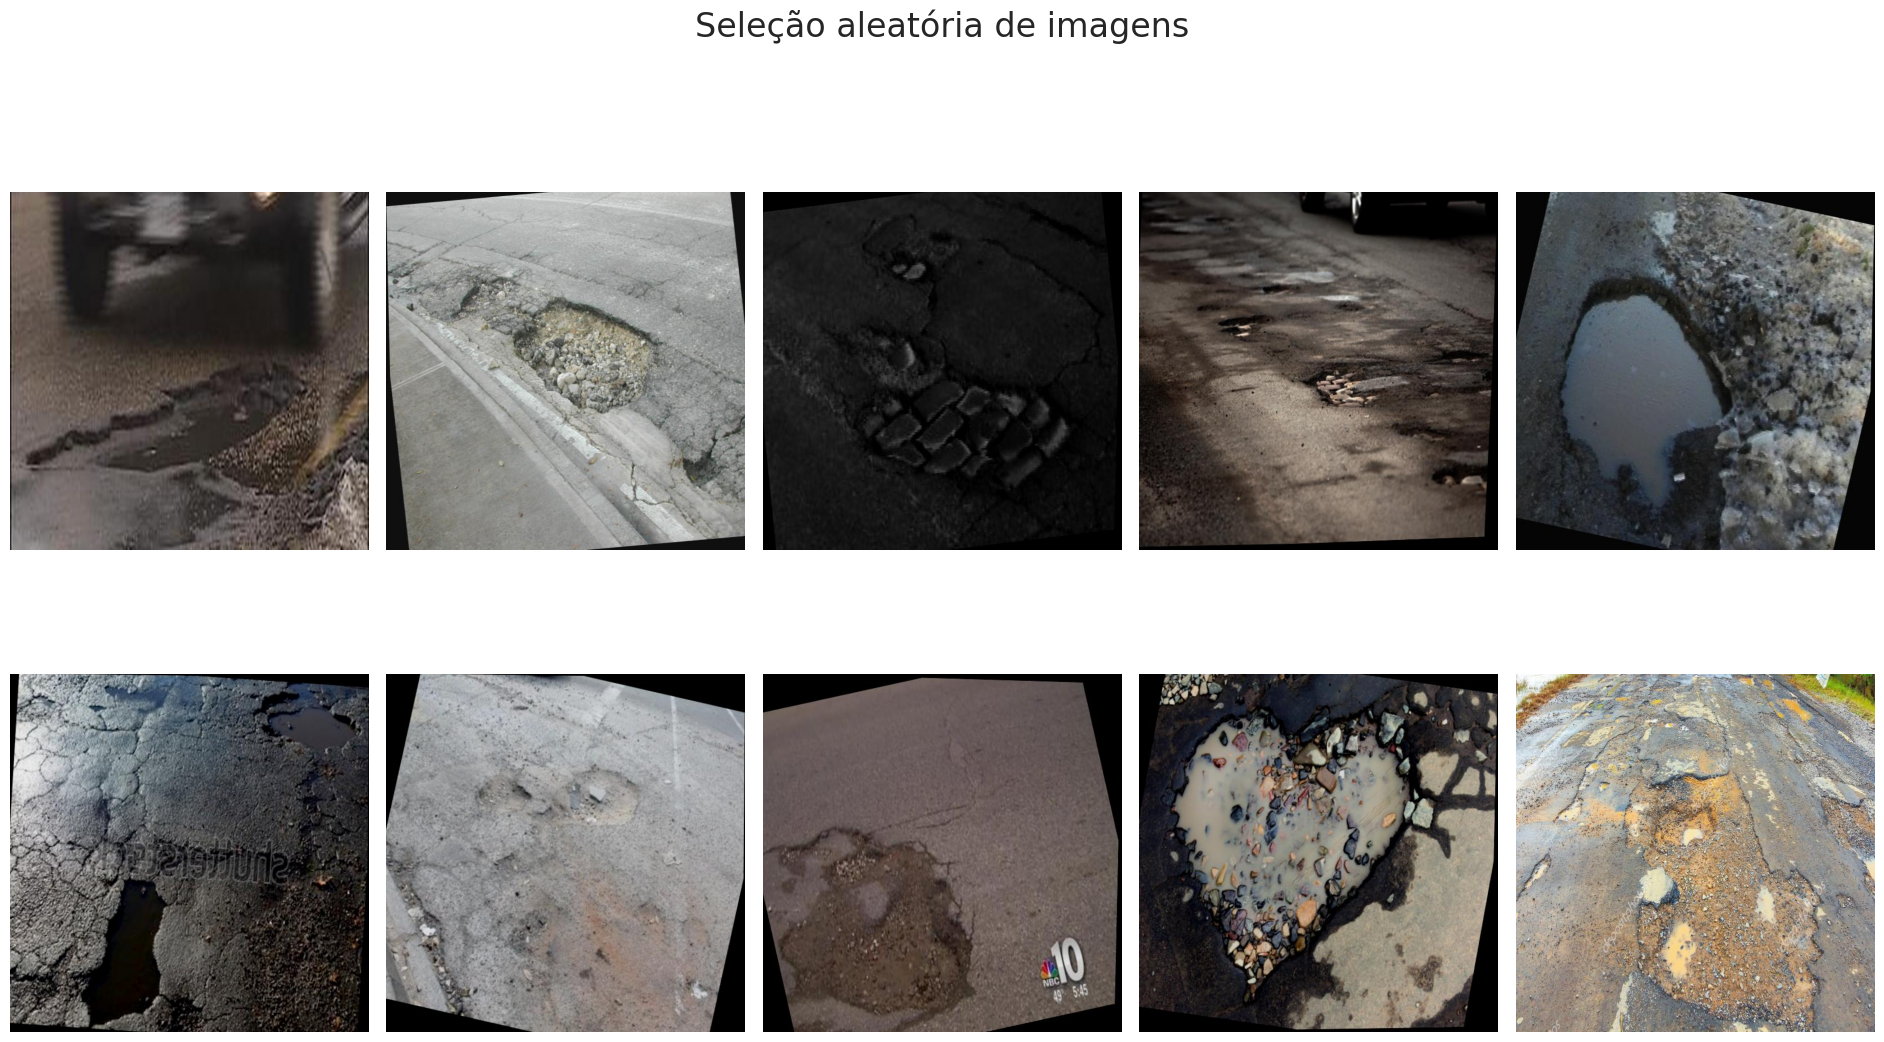

In [9]:
"""
verifica as imagens por amostragem
"""

# seta uma semente
random.seed(42)

# cria uma lista de imagens
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

# seleciona aleatoriamente 10 imagens
random_images = random.sample(image_files, 10)

# cria uma figura
plt.figure(figsize=(19, 12))

# loop em cada imagem para exibir em um grid 2 x 5
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# adiciona um título
plt.suptitle('Seleção aleatória de imagens', fontsize=24)

# exibe o plot
plt.tight_layout()
plt.show()

# deleta as imagens para liberar memória
del image_files

# 4. fine-tuning do YoLOv8n - seg

In [ ]:
"""
Neste passo, utilizamos o aprendizado por transferência para ajustar o modelo YOLOv8-seg, inicialmente treinado no conjunto de dados COCO,
para o nosso conjunto de dados. Em vez de iniciar o treinamento do zero com pesos aleatórios, o que requer muitos dados e tempo, começamos
com um modelo que já sabe reconhecer vários objetos. Dessa forma, economizamos tempo e aproveitamos ao máximo nosso conjunto de dados menor
para ensinar o modelo a identificar e segmentar buracos em imagens de estradas.
"""

# treina o modelo
results = model.train(
    data=yaml_file_path,     # caminho para o arquivo de configuração
    epochs=150,              # número de épocas de treinamento
    imgsz=640,               # tamanho do input das imagens
    patience=15,             # número de épocas para observar se há ou não melhoria no treinamento
    batch=16,                # número de imagens por batch
    optimizer='Adam',        # otimizadores [disponíveis: SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # taxa de aprendizagem inicial
    lrf=0.01,                # taxa de aprendizagem final
    dropout=0.25,            # dropout para regularização L2
    device=0,                # dispositivo para rodar (CUDA)
    seed=42                  # semente
)

# 4. performance

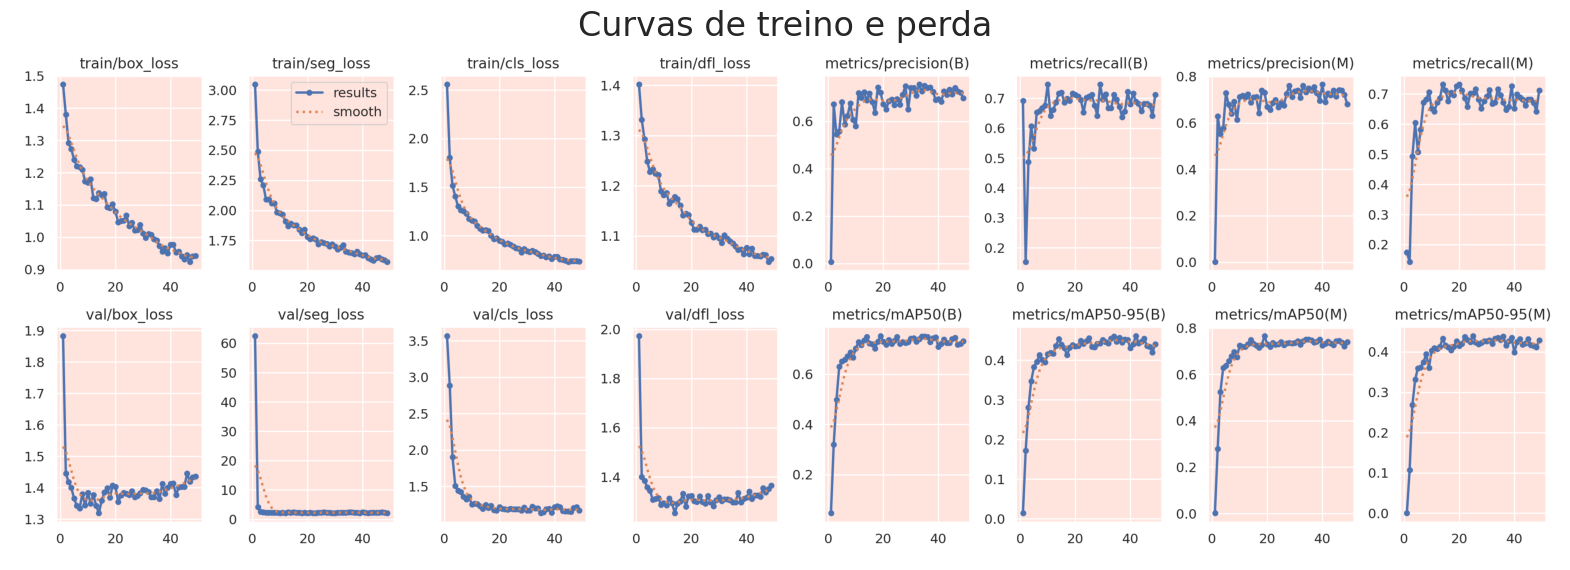

In [11]:
# diretório com o nome do arquivo de resultados
results_file_path = 'results.png'

# carrega as imagens com cv2
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# exibe com Matplotlib
plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Curvas de treino e perda', fontsize=24)
plt.axis('off')
plt.show()

In [12]:
# define uma função para plotar as curvas de aprendizagem em relação aos valores de perda
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Perda do treino', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Perda da validação', color='#ed2f00', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.ylim(ylim_range)
    plt.legend()
    plt.show()

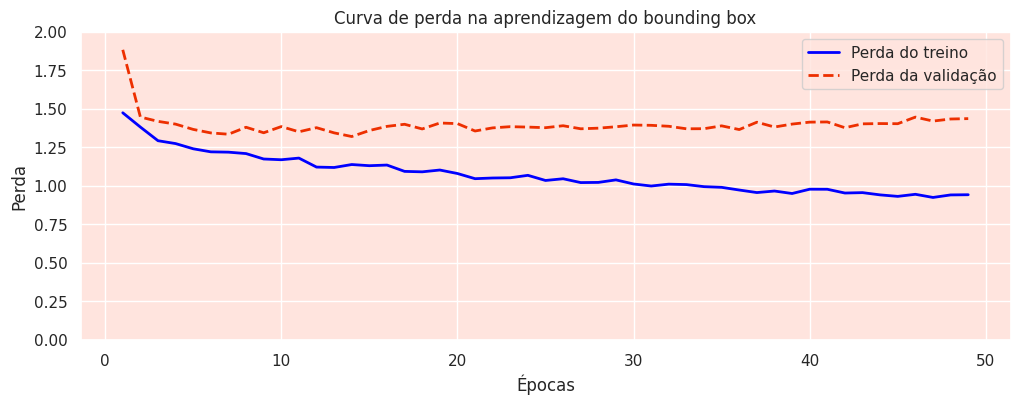

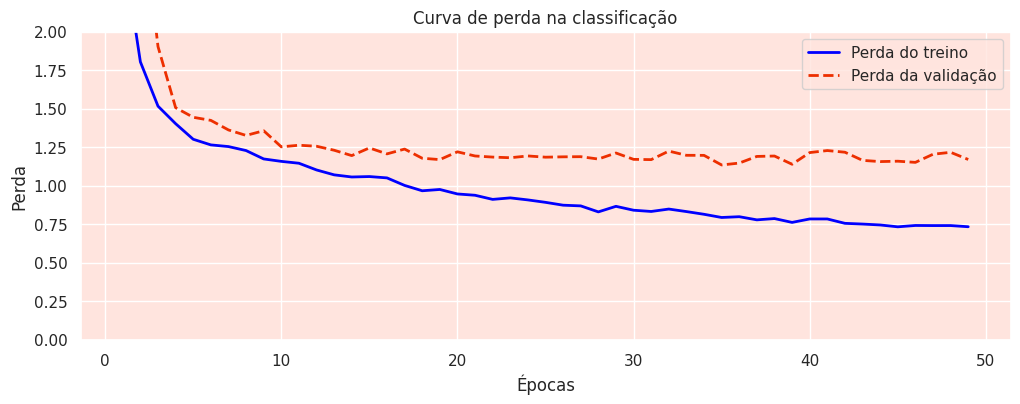

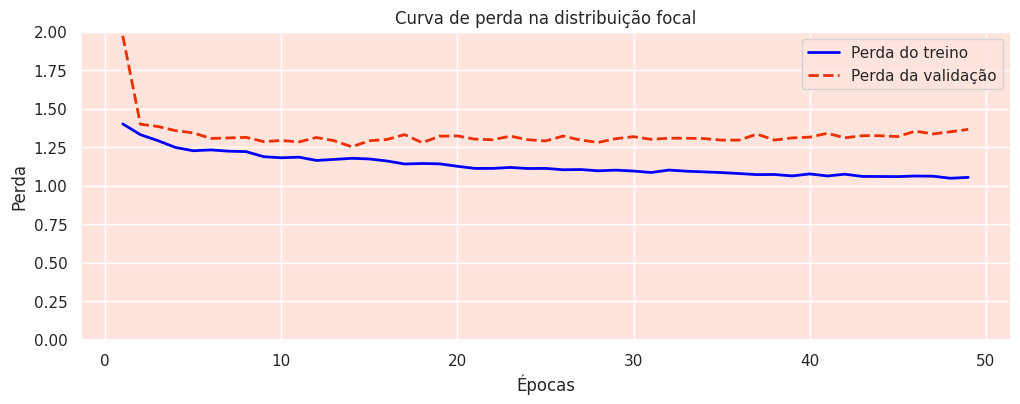

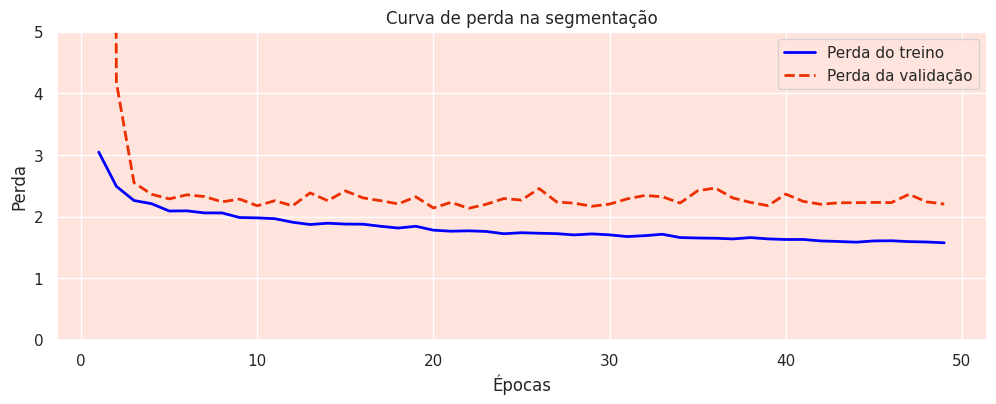

In [13]:
# diretório com o .csv dos valores de aprendizagem x loss
results_csv_path = 'results.csv'

# carrega o dataframe
df = pd.read_csv(results_csv_path)

# ajusta os textos
df.columns = df.columns.str.strip()

# plota as curvas de aprendizagem em relação as perdas
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Curva de perda na aprendizagem do bounding box')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Curva de perda na classificação')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Curva de perda na distribuição focal')
plot_learning_curve(df, 'train/seg_loss', 'val/seg_loss', 'Curva de perda na segmentação', ylim_range=[0,5])

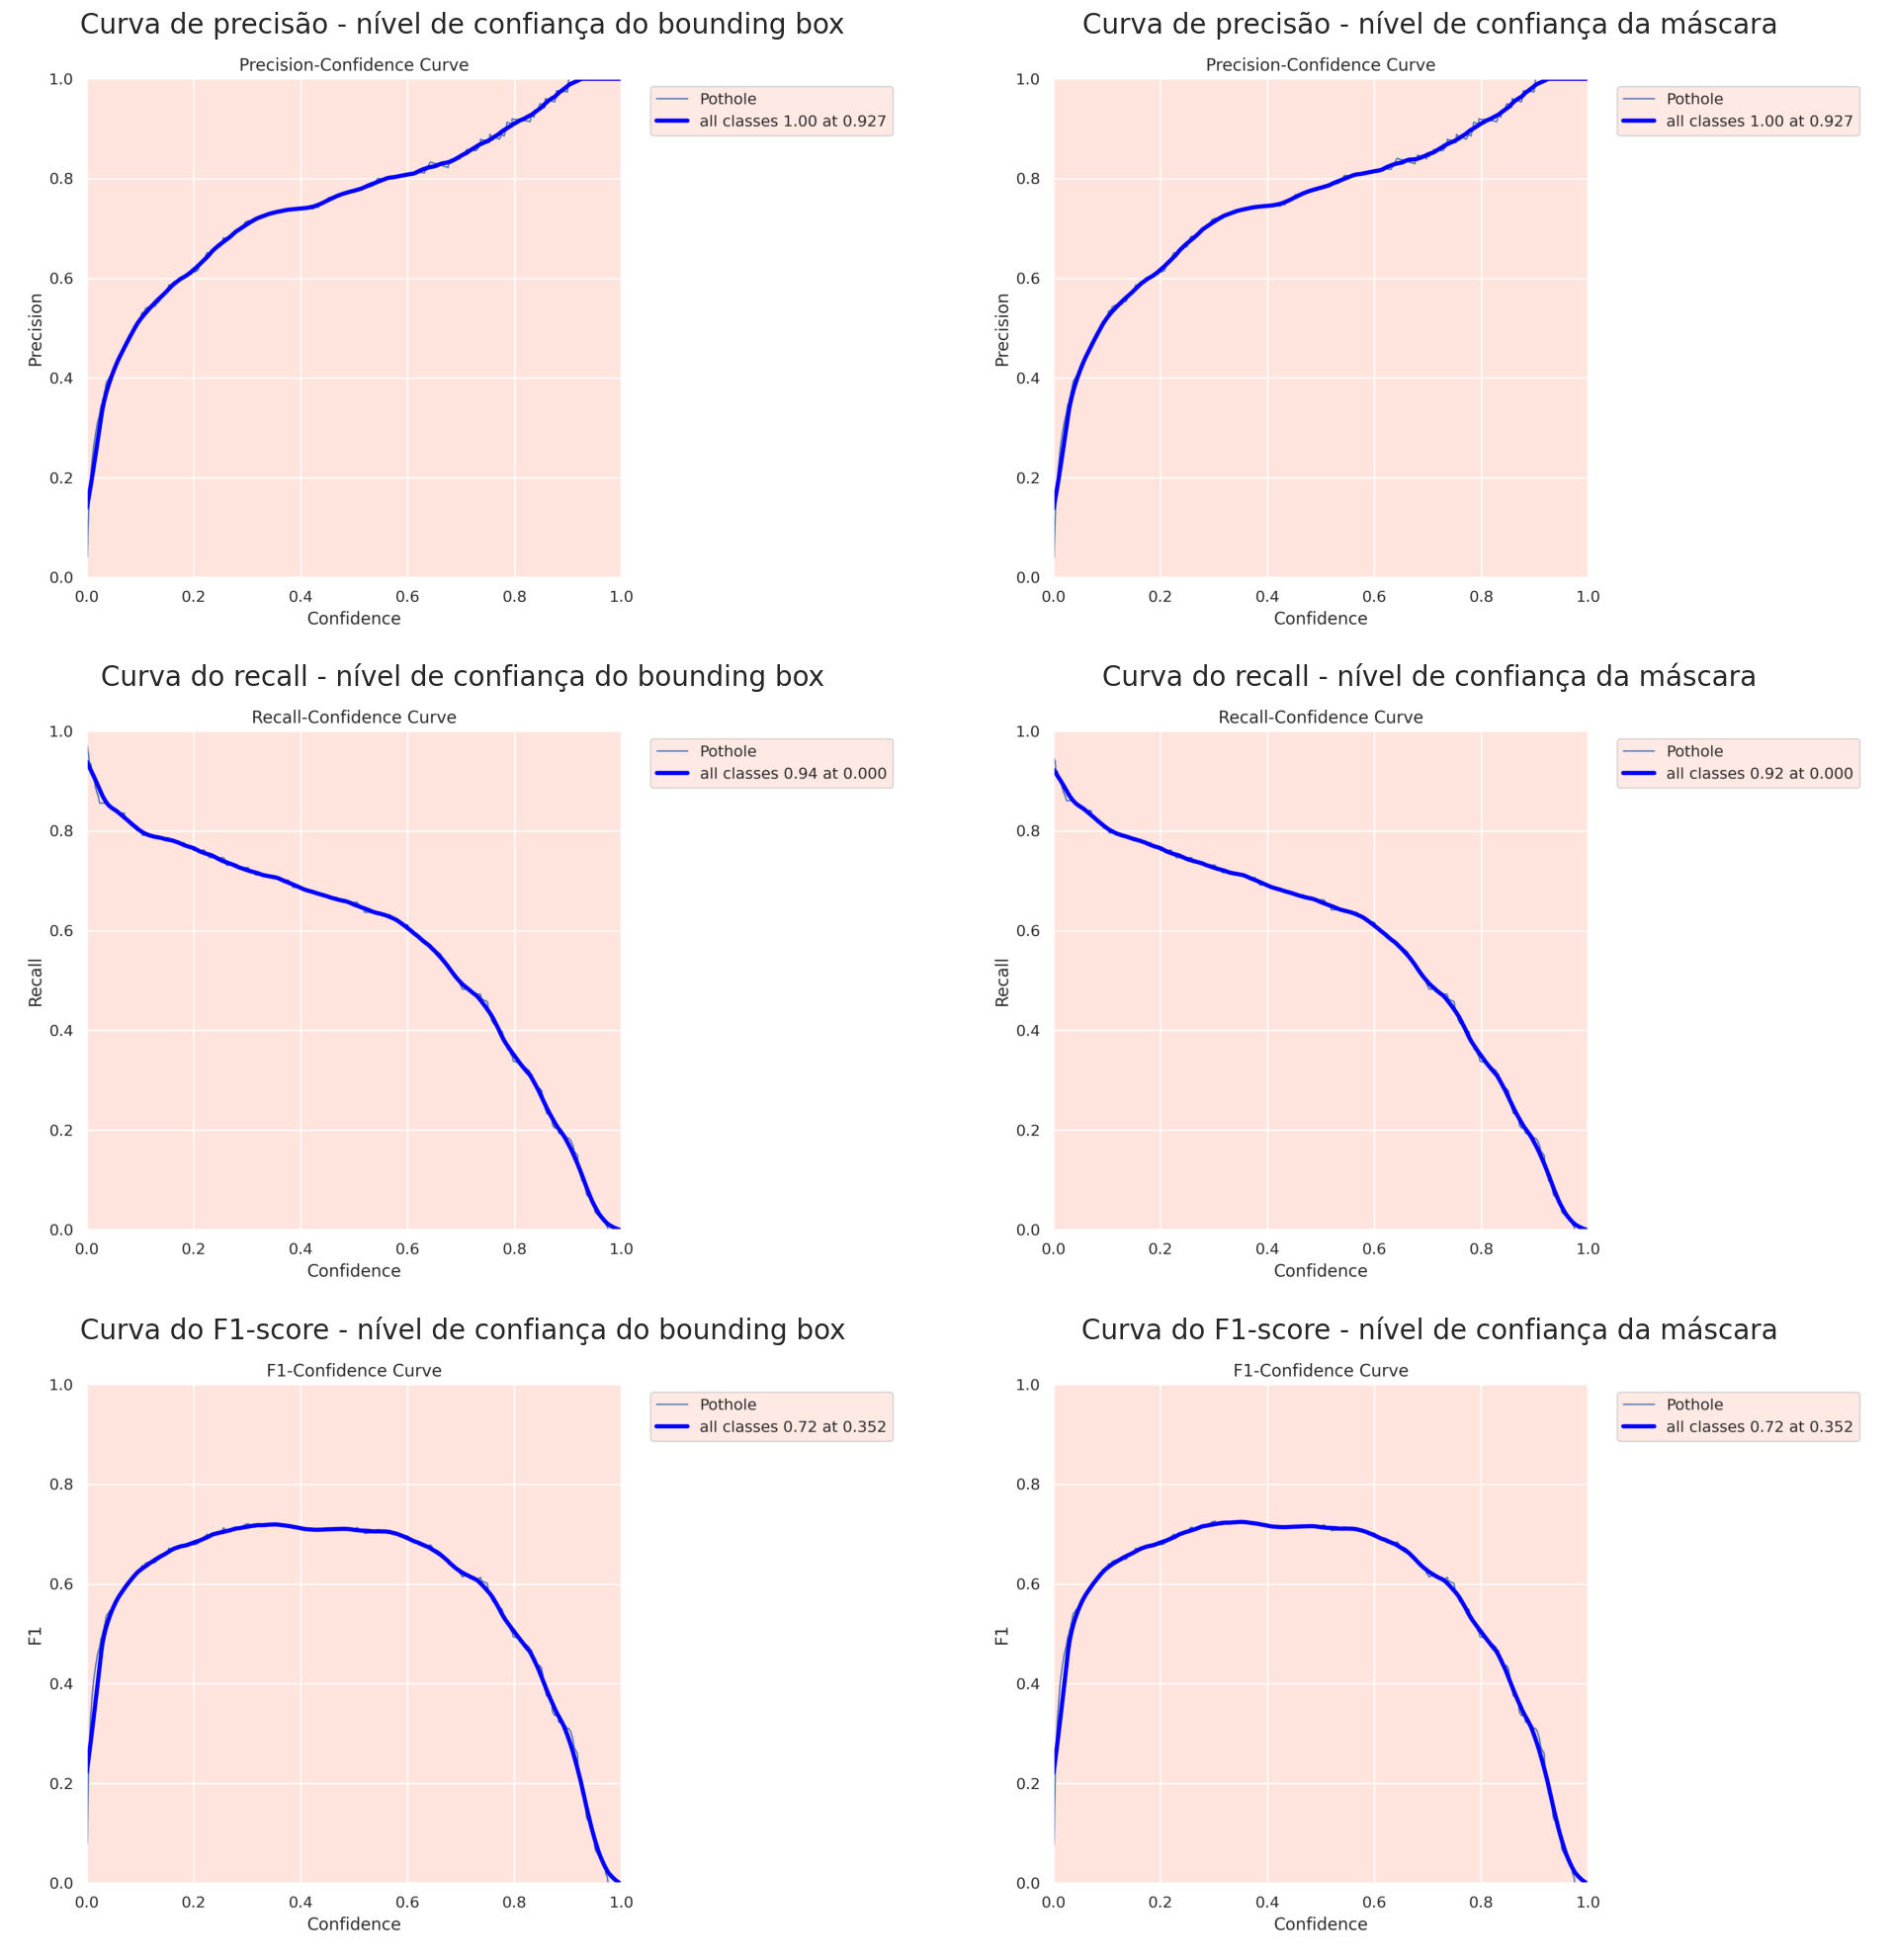

In [14]:
post_training_files_path = 'train'

# define os nomes de arquivos para 'box' e 'mask' junto com os títulos
box_files_titles = {
    'BoxP_curve.png': 'Curva de precisão - nível de confiança do bounding box',
    'BoxR_curve.png': 'Curva do recall - nível de confiança do bounding box',
    'BoxF1_curve.png': 'Curva do F1-score - nível de confiança do bounding box'
}
mask_files_titles = {
    'MaskP_curve.png': 'Curva de precisão - nível de confiança da máscara',
    'MaskR_curve.png': 'Curva do recall - nível de confiança da máscara',
    'MaskF1_curve.png': 'Curva do F1-score - nível de confiança da máscara'
}

# cria um plot 3x2
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# função para ler e converter as imagens
def read_and_convert_image(file_path):
    # carrega a imagem com cv2
    image = cv2.imread(file_path)
    # converte de BGR para RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plota as métricas dos bounding boxes
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title, fontsize=20)
    axs[i, 0].axis('off') 

# Plota as mégtricas das máscaras
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title, fontsize=20)
    axs[i, 1].axis('off')  

plt.tight_layout()
plt.show()

# 5. análise da cuva precisão-recall

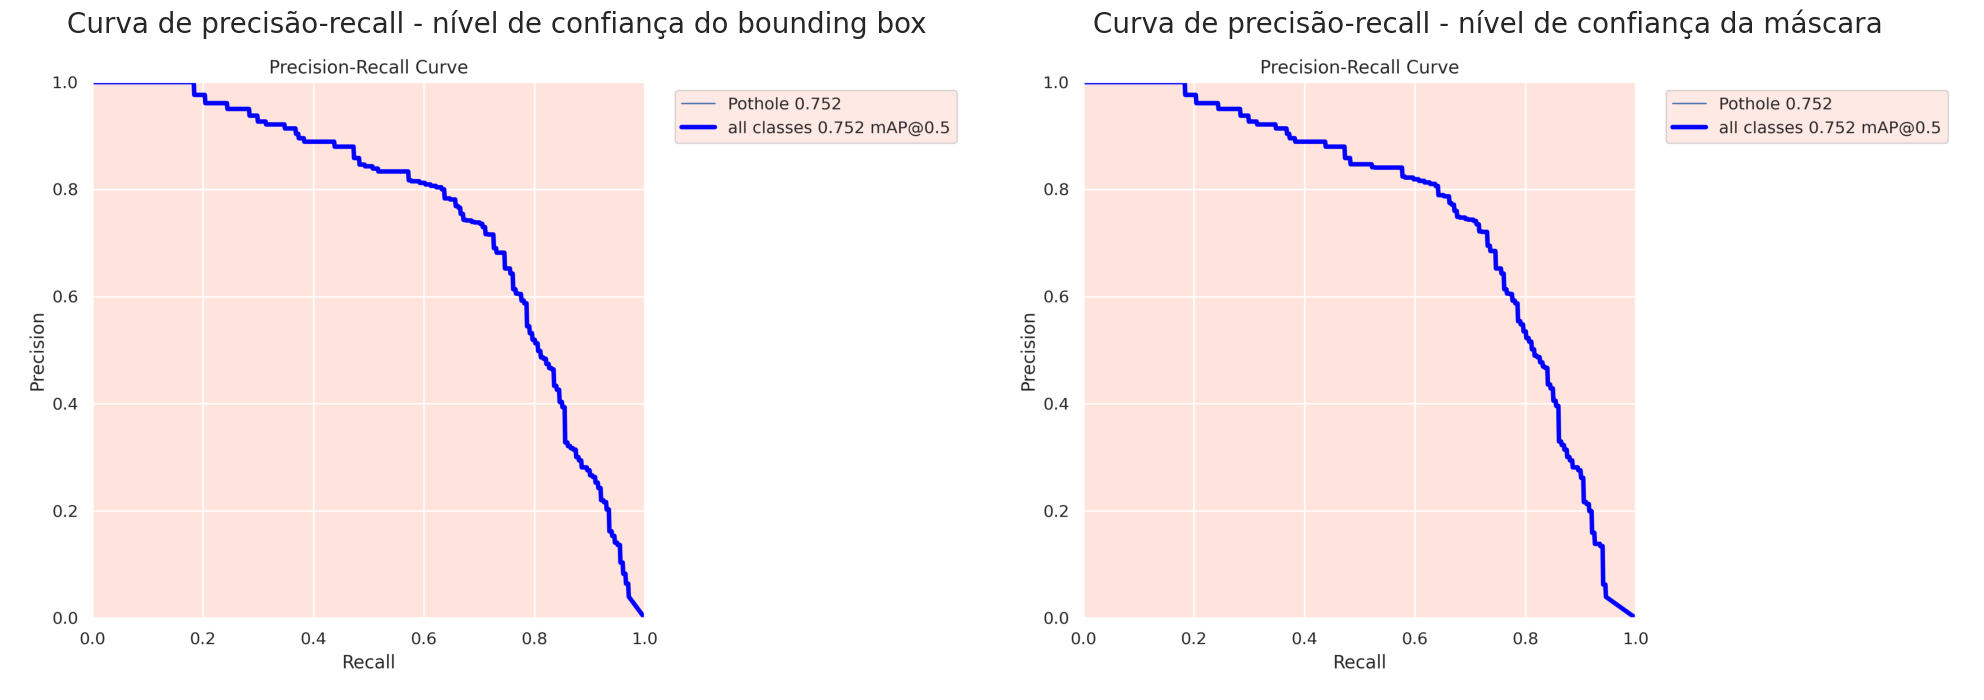

In [15]:
pr_files_titles = {
    'BoxPR_curve.png': 'Curva de precisão-recall - nível de confiança do bounding box',
    'MaskPR_curve.png': 'Curva de precisão-recall - nível de confiança da máscara'
}

# cria um subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# itera sobre os itens e plota os gráficos
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# 6. análise da matriz de confusão

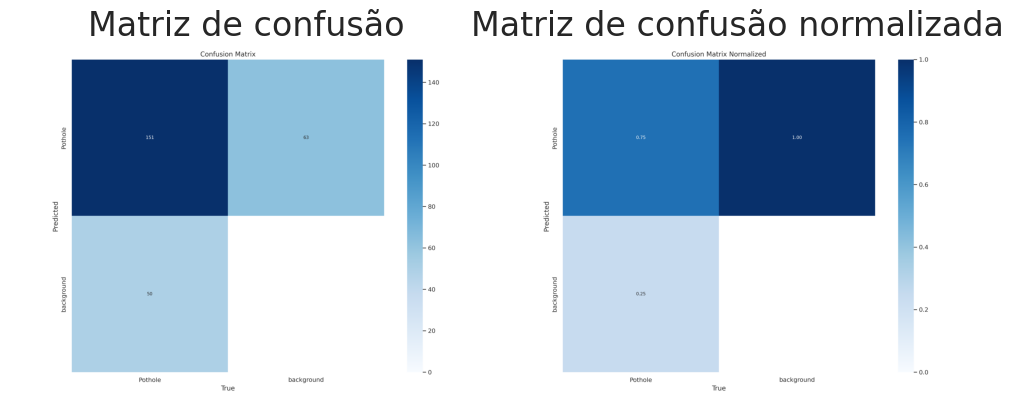

In [16]:
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# cria um plot
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# carrega as imagens e as converte
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# exibe as imagens
axs[0].imshow(cm_img)
axs[0].set_title('Matriz de confusão', fontsize=24)
axs[0].axis('off') 

axs[1].imshow(cm_norm_img)
axs[1].set_title('Matriz de confusão normalizada', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()

# 7. métricas gerais

In [ ]:
# caminho com os pesos
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# carrega os melhores pesos
best_model = YOLO(best_model_path)

# valida o melhor modelo com o dataset de validação
metrics = best_model.val(split='val')

In [18]:
# cria um dataframe com as métricas
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# exibe o dataframe
metrics_df.round(3)

,Metric Value
metrics/precision(B),0.727
metrics/recall(B),0.711
metrics/mAP50(B),0.752
metrics/mAP50-95(B),0.459
metrics/precision(M),0.732
metrics/recall(M),0.716
metrics/mAP50(M),0.752
metrics/mAP50-95(M),0.436
fitness,0.955


# 8. inferência em imagens de validação

In [ ]:
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# lista todas as imagens
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# seleciona 9 imagens em intervalos iguais
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# inicializa os subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Inferências no dataset de validação', fontsize=24)

# executa a inferência nas imagens
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

# 9. inferência em um vídeo de teste

In [ ]:
dataset_video_path = 'video_buraco_youtube_1.mp4'

# define o diretório de salvamento do vídeo renderizado
video_path = 'video_buraco_youtube_1.mp4'
# video_path = 'sample_video.mp4'

# copia o arquivo de vídeo de sua localização original no conjunto de dados para o diretório de trabalho atual
shutil.copyfile(dataset_video_path, video_path)

# inicia a detecção de buracos no vídeo de amostra usando o modelo de melhor desempenho e salva o resultado
best_model.predict(source=video_path, save=True)

In [21]:
# Converter o vídeo .avi gerado pela predição do YOLOv8 para o formato .mp4 para compatibilidade com a exibição no notebook
!ffmpeg -y -loglevel panic -i sample_video.avi processed_sample_video.mp4

# Incorporar e exibir o vídeo de exemplo processado dentro do notebook
# Video("processed_sample_video.mp4", embed=True)

#######

# Converter o vídeo .avi gerado pela predição do YOLOv8 para o formato .mp4 para compatibilidade com a exibição no notebook
!ffmpeg -y -loglevel panic -i video_buraco_youtube_1_processed.mp4

# Incorporar e exibir o vídeo de exemplo processado dentro do notebook
Video("video_buraco_youtube_1_processed.mp4", embed=True)